In [140]:
!pip install sentence-transformers catboost scikit-learn

In [141]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sentence_transformers import SentenceTransformer
from catboost import CatBoostClassifier, Pool
import joblib

In [142]:
df = pd.read_csv("/content/final_clustered.csv")
df.head()

,Content,Year,Month,Day,day_of_week,Label,Category
0,mayor of west harrow london felicitated in kandy,2018,8,7,Tuesday,neutral,Energy
1,children between years to be jabbed from jan t...,2022,1,5,Wednesday,neutral,Education
2,india sends food medicine donation to crisis h...,2022,5,23,Monday,down,Economy
3,chavakachcheri accident victims bodies airlift...,2016,12,18,Sunday,down,Technology
4,establishing sri lanka as a hub for universiti...,2023,12,11,Monday,up,Economy


In [143]:
day_map = {
    'Monday': 0,
    'Tuesday': 1,
    'Wednesday': 2,
    'Thursday': 3,
    'Friday': 4,
    'Saturday': 5,
    'Sunday': 6
}

df['day_of_week'] = df['day_of_week'].map(day_map)

df['day_of_week'] = df['day_of_week'].fillna(df['day_of_week'].mode()[0])

df['month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

df['day_sin'] = np.sin(2 * np.pi * df['Day'] / 31)
df['day_cos'] = np.cos(2 * np.pi * df['Day'] / 31)

df['dow_sin']  = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['dow_cos']  = np.cos(2 * np.pi * df['day_of_week'] / 7)

df.head()

,Content,Year,Month,Day,day_of_week,Label,Category,month_sin,month_cos,day_sin,day_cos,dow_sin,dow_cos
0,mayor of west harrow london felicitated in kandy,2018,8,7,1,neutral,Energy,-8.660254e-01,-0.500000,0.988468,0.151428,0.781831,0.623490
1,children between years to be jabbed from jan t...,2022,1,5,2,neutral,Education,5.000000e-01,0.866025,0.848644,0.528964,0.974928,-0.222521
2,india sends food medicine donation to crisis h...,2022,5,23,0,down,Economy,5.000000e-01,-0.866025,-0.998717,-0.050649,0.000000,1.000000
3,chavakachcheri accident victims bodies airlift...,2016,12,18,6,down,Technology,-2.449294e-16,1.000000,-0.485302,-0.874347,-0.781831,0.623490
4,establishing sri lanka as a hub for universiti...,2023,12,11,0,up,Economy,-2.449294e-16,1.000000,0.790776,-0.612106,0.000000,1.000000


In [144]:
df = df.drop(['Year','Day', 'Month', 'day_of_week'], axis=1)
df.head()

,Content,Label,Category,month_sin,month_cos,day_sin,day_cos,dow_sin,dow_cos
0,mayor of west harrow london felicitated in kandy,neutral,Energy,-8.660254e-01,-0.500000,0.988468,0.151428,0.781831,0.623490
1,children between years to be jabbed from jan t...,neutral,Education,5.000000e-01,0.866025,0.848644,0.528964,0.974928,-0.222521
2,india sends food medicine donation to crisis h...,down,Economy,5.000000e-01,-0.866025,-0.998717,-0.050649,0.000000,1.000000
3,chavakachcheri accident victims bodies airlift...,down,Technology,-2.449294e-16,1.000000,-0.485302,-0.874347,-0.781831,0.623490
4,establishing sri lanka as a hub for universiti...,up,Economy,-2.449294e-16,1.000000,0.790776,-0.612106,0.000000,1.000000


In [145]:
category_map = {
    "Energy":0,
    "Logistics":1,
    "Education":2,
    "Health":3,
    "Finance":4,
    "Government":5,
    "Tourism":6,
    "Agriculture":7,
    "Social":8,
    "Technology":9,
    "Economy":10,
    "Other":11
}
df['CategoryID'] = df['Category'].map(category_map)
df.head()

,Content,Label,Category,month_sin,month_cos,day_sin,day_cos,dow_sin,dow_cos,CategoryID
0,mayor of west harrow london felicitated in kandy,neutral,Energy,-8.660254e-01,-0.500000,0.988468,0.151428,0.781831,0.623490,0
1,children between years to be jabbed from jan t...,neutral,Education,5.000000e-01,0.866025,0.848644,0.528964,0.974928,-0.222521,2
2,india sends food medicine donation to crisis h...,down,Economy,5.000000e-01,-0.866025,-0.998717,-0.050649,0.000000,1.000000,10
3,chavakachcheri accident victims bodies airlift...,down,Technology,-2.449294e-16,1.000000,-0.485302,-0.874347,-0.781831,0.623490,9
4,establishing sri lanka as a hub for universiti...,up,Economy,-2.449294e-16,1.000000,0.790776,-0.612106,0.000000,1.000000,10


In [146]:
df = df.drop(['Category'], axis=1)
df.head()

,Content,Label,month_sin,month_cos,day_sin,day_cos,dow_sin,dow_cos,CategoryID
0,mayor of west harrow london felicitated in kandy,neutral,-8.660254e-01,-0.500000,0.988468,0.151428,0.781831,0.623490,0
1,children between years to be jabbed from jan t...,neutral,5.000000e-01,0.866025,0.848644,0.528964,0.974928,-0.222521,2
2,india sends food medicine donation to crisis h...,down,5.000000e-01,-0.866025,-0.998717,-0.050649,0.000000,1.000000,10
3,chavakachcheri accident victims bodies airlift...,down,-2.449294e-16,1.000000,-0.485302,-0.874347,-0.781831,0.623490,9
4,establishing sri lanka as a hub for universiti...,up,-2.449294e-16,1.000000,0.790776,-0.612106,0.000000,1.000000,10


In [147]:
df['CategoryID'].value_counts()

,count
CategoryID,
6,25377
0,22935
10,19277
5,18420
4,16052
1,15121
7,12625
9,11944
2,11004


In [148]:
# 2. Text Embeddings (MiniLM)
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

X_text = df["Content"].tolist()
X_text_emb = model.encode(
    X_text,
    batch_size=32,
    show_progress_bar=True,
    convert_to_numpy=True,
)

Batches:   0%|          | 0/5625 [00:00<?, ?it/s]

In [149]:
X_time = df[['month_sin','month_cos','dow_sin','dow_cos']].to_numpy()
X = np.hstack([X_text_emb, X_time])
y = df["CategoryID"].values

In [150]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [151]:
# Define the class weights
class_weights = {
    0: 1.106,
    1: 1.679,
    2: 2.306,
    3: 2.647,
    4: 1.582,
    5: 1.378,
    6: 1.0,
    7: 2.009,
    8: 2.457,
    9: 2.124,
    10: 1.316,
    11: 3.46
}

In [152]:
cat_features = []

cb = CatBoostClassifier(
    iterations=600,
    depth=6,
    learning_rate=0.08,
    loss_function='MultiClass',
    class_weights=class_weights,
    eval_metric='Accuracy',
    l2_leaf_reg=7,
    random_seed=42,
    task_type='GPU',
    verbose=50,
    use_best_model=True
)

cb.fit(X_train, y_train, eval_set=(X_test, y_test), cat_features=cat_features, early_stopping_rounds=50)

0:	learn: 0.3720467	test: 0.3688770	best: 0.3688770 (0)	total: 111ms	remaining: 1m 6s
50:	learn: 0.8257200	test: 0.8174404	best: 0.8174404 (50)	total: 3.05s	remaining: 32.9s
100:	learn: 0.8855869	test: 0.8725148	best: 0.8726537 (99)	total: 5.91s	remaining: 29.2s
150:	learn: 0.9137531	test: 0.8984584	best: 0.8984584 (150)	total: 8.71s	remaining: 25.9s
200:	learn: 0.9310789	test: 0.9118901	best: 0.9118901 (200)	total: 12.3s	remaining: 24.4s
250:	learn: 0.9436382	test: 0.9231796	best: 0.9231796 (250)	total: 15.1s	remaining: 20.9s
300:	learn: 0.9528173	test: 0.9296511	best: 0.9296511 (300)	total: 17.7s	remaining: 17.6s
350:	learn: 0.9605056	test: 0.9347129	best: 0.9349341 (347)	total: 20.3s	remaining: 14.4s
400:	learn: 0.9661398	test: 0.9389899	best: 0.9389899 (400)	total: 23.7s	remaining: 11.7s
450:	learn: 0.9703002	test: 0.9423763	best: 0.9423763 (450)	total: 26.3s	remaining: 8.68s
500:	learn: 0.9737540	test: 0.9447956	best: 0.9449026 (496)	total: 28.7s	remaining: 5.67s
550:	learn: 0.976

In [153]:
y_pred = cb.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.92      0.93      4587
           1       0.92      0.91      0.91      3024
           2       0.97      0.98      0.98      2201
           3       0.97      0.98      0.98      1919
           4       0.93      0.93      0.93      3210
           5       0.93      0.94      0.93      3684
           6       0.96      0.93      0.94      5076
           7       0.95      0.96      0.96      2525
           8       0.91      0.94      0.93      2064
           9       0.94      0.96      0.95      2389
          10       0.96      0.96      0.96      3855
          11       0.92      0.96      0.94      1466

    accuracy                           0.94     36000
   macro avg       0.94      0.95      0.95     36000
weighted avg       0.94      0.94      0.94     36000



In [154]:
from sklearn.metrics import accuracy_score

# Predict on training data
y_pred_train = cb.predict(X_train)
train_acc = accuracy_score(y_train, y_pred_train)

# Predict on test data
y_pred_test = cb.predict(X_test)
test_acc = accuracy_score(y_test, y_pred_test)

print("Training Accuracy:", train_acc)
print("Test Accuracy:", test_acc)

Training Accuracy: 0.9737638888888889
Test Accuracy: 0.9432222222222222


In [155]:
joblib.dump(cb, "news_catboost_classifier.pkl", compress=3)

['news_catboost_classifier.pkl']

Cyclic features importance:
month_sin: 0.1323
month_cos: 0.5301
day_sin: 0.0000
day_cos: 0.0000
dow_sin: 0.0000
dow_cos: 0.0000


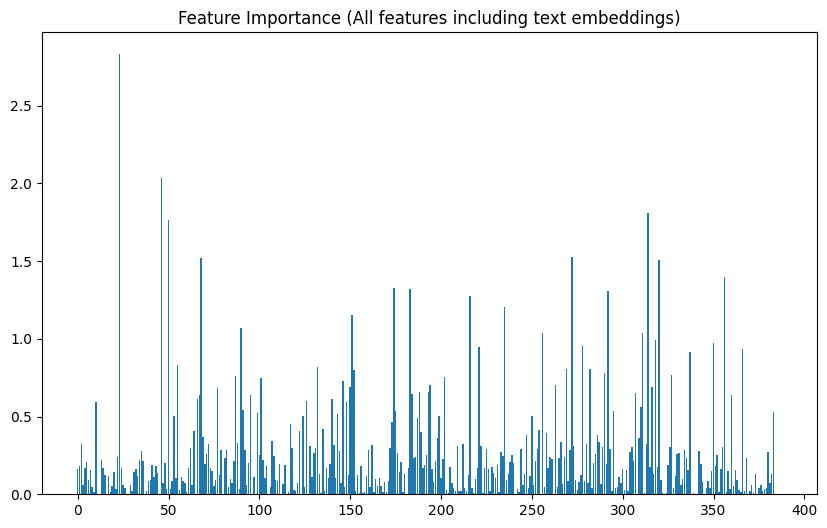

In [156]:
import matplotlib.pyplot as plt

# Get importance
importances = cb.get_feature_importance()
# Last 6 features are cyclic features
cyclic_features = ['month_sin','month_cos','day_sin','day_cos','dow_sin','dow_cos']
print("Cyclic features importance:")
for i, feat in enumerate(cyclic_features):
    print(f"{feat}: {importances[-6 + i]:.4f}")

# Optionally, plot top features
plt.figure(figsize=(10,6))
plt.bar(range(len(importances)), importances)
plt.title("Feature Importance (All features including text embeddings)")
plt.show()